<a href="https://colab.research.google.com/github/jonmcwong/N-HPatchesModels/blob/master/DescriptorNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

READ ME:

The training of the denoiser followed by descriptor has been split into two notebooks.

This is the notebook for the descriptor network. It requires a "denoise_model.h5" to be found in the directory at the "path" variable.

## Safety Check

As Google Colab is an external platform, we cannot guarantee that everytime you connect to a remote server, you will have the same amount of RAM or video RAM. For that reason, we will first check the amount of memory we have in the notebook. RAM should be around 12.9 GB, which is enough to load the datasets in memory. Also, usually, we have available 11.4 GB of GPU memory, which is more than enough to run this code. However, some users reported having only 500 MB of GPU memory. If you have that amount, restart the environment to see if you get the corresponding 11.4 GB.

In [1]:
# Taken from
# https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# Colab only provides one GPU and it is not always guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [2]:
printm()

('RAM Free: 12.9 GB', ' | Proc size: 152.7 MB')
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


## Downloading Functions and Data

The first step is to clone the GitHub repository of the course, which contains already implemented functions. You can use your own function and import them here doing the same. In addition, we are going to download and extract the N-HPatches data. 

As a note, in colab, we can run terminal commands by using ```!```. Also, by using ```%``` we have access to the [built-in IPython magic commands](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-cd), which we will use to move through directories (`cd` command). It takes around 5 minutes to download and unzip the dataset. 


In [49]:
!rm -rf keras_triplet_descriptor
# Clone repo
!git clone https://github.com/MatchLab-Imperial/keras_triplet_descriptor

Cloning into 'keras_triplet_descriptor'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 181 (delta 0), reused 1 (delta 0), pack-reused 178
Receiving objects: 100% (181/181), 149.87 MiB | 21.02 MiB/s, done.
Resolving deltas: 100% (65/65), done.
Checking out files: 100% (69/69), done.


In [50]:
# Change directory
%cd /content/keras_triplet_descriptor    


/content/keras_triplet_descriptor


In [54]:
# Download data
!wget -O hpatches_data.zip https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip


--2019-03-22 13:07:39--  https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.box.com (imperialcollegelondon.box.com)... 107.152.26.197, 107.152.27.197
Connecting to imperialcollegelondon.box.com (imperialcollegelondon.box.com)|107.152.26.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip [following]
--2019-03-22 13:07:39--  https://imperialcollegelondon.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Reusing existing connection to imperialcollegelondon.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://imperialcollegelondon.app.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip [following]
--2019-03-22 13:07:39--  https://imperialcollegelondon.app.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.app.box.com (imperialcolleg

In [55]:
# Extract data
!unzip -q ./hpatches_data.zip
!rm ./hpatches_data.zip

replace hpatches/v_man/e3.anisjitter? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace hpatches/v_man/t1.overlaps? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace hpatches/v_man/e5.anisjitter? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace hpatches/v_man/e1.anisjitter? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace hpatches/v_man/e4_noise.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


## Importing Necessary Modules

We now import the modules we will use in this baseline code. 

In [0]:
import sys
import json
import os
import glob
import time
import tensorflow as tf
import numpy as np
import cv2
import random

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization 
from keras.layers import Input, UpSampling2D, concatenate
from keras.callbacks import ReduceLROnPlateau

from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet

The `read_data` and `utils` imports are functions provided in the repository we just cloned. You can navigate through the *File tab* and check what those functions do for a better understanding.

![texto del enlace](https://i.ibb.co/HnfSvfT/filetab.png)





We also fix the seeds of the pseudo-random number generators to have reproducible results. The idea of fixing the seed is having the same results every time the algorithm is run if there are no changes in the code.

In [0]:
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

Now we load the data. The original HPatches dataset has several splits, which are used to separate the available sequences in train sequences and test sequences. For our experiments in N-HPatches we use the same splits as in HPatches. Specifically, we load (and report results) using the split `'a'`:


In [0]:
hpatches_dir = './hpatches'
splits_path = './splits.json'

splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   
seqs_train = list(filter(lambda x: x.split('/')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('/')[-1] in split['test'], seqs)) 


In [58]:
seqs_test


['/content/keras_triplet_descriptor/hpatches/i_salon',
 '/content/keras_triplet_descriptor/hpatches/v_fest',
 '/content/keras_triplet_descriptor/hpatches/i_bridger',
 '/content/keras_triplet_descriptor/hpatches/v_birdwoman',
 '/content/keras_triplet_descriptor/hpatches/v_eastsouth',
 '/content/keras_triplet_descriptor/hpatches/v_abstract',
 '/content/keras_triplet_descriptor/hpatches/v_busstop',
 '/content/keras_triplet_descriptor/hpatches/v_underground',
 '/content/keras_triplet_descriptor/hpatches/v_soldiers',
 '/content/keras_triplet_descriptor/hpatches/i_fruits',
 '/content/keras_triplet_descriptor/hpatches/i_table',
 '/content/keras_triplet_descriptor/hpatches/i_porta',
 '/content/keras_triplet_descriptor/hpatches/i_fog',
 '/content/keras_triplet_descriptor/hpatches/i_lionnight',
 '/content/keras_triplet_descriptor/hpatches/i_autannes',
 '/content/keras_triplet_descriptor/hpatches/v_man',
 '/content/keras_triplet_descriptor/hpatches/i_nijmegen',
 '/content/keras_triplet_descriptor

## Models and loss

We now define three functions that define the main modules of our baseline. 

*   **get_denoise_model(..)** returns the denoising model. The input for the function is the size of the patch, which will be *1x32x32*, and it outputs a keras denoising model. 
*   **get_descriptor_model(..)** builts the descriptor model. The input for the function is the size of the patch, which will be *1x32x32*, and it outputs a keras descriptor model. The model we use as baseline returns a descriptor of dimension *128x1*.
*   **triplet_loss(..)** defines the loss function which is used to train the descriptor model. 

You can modify the models in these functions and run the training code again. For example, the given denoising model is quite shallow, maybe using a deeper network can improve results. Or testing new initializations for the weights. Or maybe adding dropout. Or modifying the loss function somehow...

In [0]:
def get_denoise_model(shape):
    
  inputs = Input(shape)
  
  ## Encoder starts
  conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  
  ## Bottleneck
  conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)

  ## Now the decoder starts
  up3 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv2))
  merge3 = concatenate([conv1,up3], axis = -1)
  conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge3)
    
  conv4 = Conv2D(1, 3,  padding = 'same')(conv3)

  shallow_net = Model(inputs = inputs, outputs = conv4)
  
  return shallow_net



def get_descriptor_model(shape):
  
  '''Architecture copies HardNet architecture'''
  
  init_weights = keras.initializers.he_normal()
  
  descriptor_model = Sequential()
  descriptor_model.add(Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', strides=2, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', strides=2,  use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))
  descriptor_model.add(Dropout(0.3))

  descriptor_model.add(Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer=init_weights))
  
  # Final descriptor reshape
  descriptor_model.add(Reshape((128,)))
  
  return descriptor_model
  
  
def triplet_loss(x): #added negative mining
  
  output_dim = 128
  a, p, n = x
  _alpha = 1.0
  positive_distance = K.mean(K.square(a - p), axis=-1)
  negative_distance = K.mean(K.square(a - n), axis=-1)
  negative_distance_2 = K.mean(K.square(p - n), axis=-1)
  negative_distance = K.minimum(negative_distance, negative_distance_2)
  
  return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)


## Denoising Image Patches


We use the *DenoiseHPatches* class implemented in the read_data.py file, which takes as input the list of sequences to load and the size of batches. 

*DenoiseHPatches* outputs batches where the input data is the noisy image and the label is the clean image, so we can use a mean absolute error (MAE) metric as loss function. You can try to use different metrics here to see if that improves results. 

Afterward, we take a subset of training and validation sequences by using *random.sample* (3 sequences for training and 1 for validation data). The purpose of doing so is just to speed-up training when trying different setups, but you should use the whole dataset when training your final model. Remove the random.sample function to give the generator all the training data.

In addition, note that we are using the test set as validation. We will provide you with a new test set that will be used to evaluate your final model, and from which you will not have the clean images. 

**Updated**: Training should be quite faster now (1 epoch around 15 minutes).

In [11]:
!pip install tensorboardcolab
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-03-22 11:18:53--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 35.173.3.255, 34.232.181.106, 35.173.6.94, ...
Connecting to bin.equinox.io (bin.equinox.io)|35.173.3.255|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13584026 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  12.95M  64.7MB/s    in 0.2s    

2019-03-22 11:18:54 (64.7 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13584026/13584026]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [31]:
import tensorboardcolab as tbc
K.clear_session()
tboard = tbc.TensorBoardColab()
from tensorboardcolab import TensorBoardColabCallback

Wait for 8 seconds...
TensorBoard link:
https://ef0bd6ac.ngrok.io


In [0]:
shape = (32, 32, 1)


We set number of epochs to 1, tweak it, along with other hyperparameters, to improve the performance of the model.

In [14]:
# Load the Drive helper and mount
from google.colab import drive

#set working directory in google drive so that we can import models and history
path = '/content/drive/My\ Drive/0Spring/DeepLearning/Hardnet'

# This will prompt for authorization.
drive.mount('/content/drive')
!ls


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
Baseline_code.ipynb  ngrok			   README.md	utils.pyc
hpatches	     ngrok-stable-linux-amd64.zip  splits.json
hpatches-benchmark   read_data.py		   tasks
Images		     read_data.pyc		   utils.py


In [16]:
%cd $path


/content/drive/My Drive/0Spring/DeepLearning/Hardnet


## Training a Descriptor Network
In the last section we trained a model that given a noisy patch, outputs a denoised version of it. We hoped that by doing so, we will improve the performance of the second part, which is training a network that outputs the descriptor. As we mentioned, a descriptor is a numerical vector that represents the small images we have. The dataset consists of a large number of small images, which are cropped patches from other larger images. Hence, they represent some local part of a scene. That is why there are no objects represented, only corners or textures. Each of these patches is related to a subset of other patches of the dataset by some kind of geometric transformation (e.g. rotation).  For a given patch, we want the network to output a vector that is close to the vectors of the patches that represent the same local part of a scene, while being far from patches do not represent that local part of a scene.

To do so, we will build a convolutional neural network that takes the input of $32\times32$ and outputs a descriptor of size $128$. For the loss, we use the triplet loss, which takes an anchor patch, a negative patch and a positive patch. The idea is to train the network so the descriptors from the anchor and positive patch have a low distance between them, and the negative and anchor patch have a large distance between them. 

In this cell we generate a triplet network, which is a network formed by three copies of the same network. That means that the descriptor model will compute the descriptor for the input `'a'` (anchor), the same descriptor model (with the same weights) will compute the descriptor for the input `'p'` (positive), and again the same model will compute the descriptor for the input `'n'` (negative). 

**Updated explanation**: Due to the way Keras handles the compile method, it needs a loss as an argument in that compile method. However, our loss is computed in the lambda layer, so we want to minimize the output of that layer. As we want to minimize the output of the Lambda function (in this case the triplet loss), we output as the label in the training_generator a vector of zeros and we compute the mean absolute error of the triplet loss and this vector of zeros. To give you an intuition, what we aim to minimize is
$$  |\text{triplet_loss} - 0| =  |\text{triplet_loss}| = \text{triplet_loss} $$



In [0]:
from keras.layers import Lambda
shape = (32, 32, 1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')
descriptor_model = get_descriptor_model(shape)
ea = descriptor_model(xa)
ep = descriptor_model(xp)
en = descriptor_model(xn)

loss = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_trip = Model(inputs=[xa, xp, xn], outputs=loss)
sgd = keras.optimizers.SGD(lr=0.1)
adamax = keras.optimizers.Adamax()
descriptor_model_trip.compile(loss='mean_absolute_error', optimizer=adamax)

Here we use the class HPatches, which loads the corresponding files by using the method `read_image_file`. It reads the patches. The output of read_image_file is a tuple of the form (images, labels), which is passed to the class `DataGeneratorDesc`. This class is a generator that creates batches of triplets, and each epoch is defined by the number of triplets in the argument `num_triplets`.

**Updated**: In the previous version of the baseline code, we were training the descriptor model with the noisy patches, not with the denoised ones. By adding the argument `denoise_model=denoise_model` to the class HPatches we can use the denoised images instead to train this descriptor model (if `denoise_model=None`, the noisy patches will be used). However, as it has to compute the denoised patch first, the loading of the data will be slower (6/7 extra min).  If you want to train the model with the clean patches instead, you can set the argument `use_clean=True`. In this last case, even if a denoise model is given, it will not be used. When running this piece of code **the type of patches (denoised, noisy or clean) used is printed**.

In [60]:
%cd $path
denoise_model = keras.models.load_model('./denoise_model.h5')
%cd /content/keras_triplet_descriptor
#hpatches_dir.shape()
!ls



/content/drive/My Drive/0Spring/DeepLearning/Hardnet
/content/keras_triplet_descriptor
Baseline_code.ipynb  Images			   read_data.py   utils.py
descriptor.h5	     keras_triplet_descriptor	   read_data.pyc  utils.pyc
Graph		     ngrok			   README.md
hpatches	     ngrok-stable-linux-amd64.zip  splits.json
hpatches-benchmark   out			   tasks


In [69]:

### Descriptor loading and training
# Loading images
hPatches = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=denoise_model, use_clean=False)
# Creating training generator
training_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=1), 
                                       num_triplets=100000)
# Creating validation generator
val_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=0), num_triplets=10000)


Using denoised patches


  0%|          | 0/116 [00:00<?, ?it/s]

  1%|          | 1/116 [00:00<01:15,  1.52it/s]

  3%|▎         | 3/116 [00:01<01:04,  1.76it/s]

  3%|▎         | 4/116 [00:01<00:59,  1.87it/s]

  6%|▌         | 7/116 [00:02<00:43,  2.50it/s]

  8%|▊         | 9/116 [00:02<00:41,  2.56it/s]

  9%|▊         | 10/116 [00:03<00:53,  2.00it/s]

  9%|▉         | 11/116 [00:04<00:52,  1.99it/s]

 10%|█         | 12/116 [00:04<00:44,  2.33it/s]

 12%|█▏        | 14/116 [00:05<00:41,  2.43it/s]

 14%|█▍        | 16/116 [00:05<00:35,  2.84it/s]

 15%|█▍        | 17/116 [00:06<00:42,  2.34it/s]

 16%|█▌        | 18/116 [00:06<00:38,  2.57it/s]

 17%|█▋        | 20/116 [00:06<00:30,  3.12it/s]

 20%|█▉        | 23/116 [00:07<00:26,  3.50it/s]

 21%|██        | 24/116 [00:08<00:38,  2.37it/s]

 22%|██▏       | 25/116 [00:08<00:33,  2.75it/s]

 22%|██▏       | 26/116 [00:09<00:43,  2.07it/s]

 23%|██▎       | 27/116 [00:09<00:39,  2.24it/s]

 26%|██▌       | 30/116 [00:09<00:29,  



  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 5547/2000000 [00:00<00:35, 55465.03it/s]

  1%|          | 13483/2000000 [00:00<00:32, 60971.32it/s]

  1%|          | 21647/2000000 [00:00<00:30, 65893.13it/s]

  2%|▏         | 30123/2000000 [00:00<00:27, 70607.30it/s]

  2%|▏         | 38191/2000000 [00:00<00:26, 73354.34it/s]

  2%|▏         | 45505/2000000 [00:00<00:26, 73285.72it/s]

  3%|▎         | 52326/2000000 [00:01<01:20, 24222.43it/s]

  3%|▎         | 59854/2000000 [00:01<01:03, 30409.92it/s]

  3%|▎         | 67895/2000000 [00:01<00:51, 37379.35it/s]

  4%|▎         | 74736/2000000 [00:01<00:44, 43266.79it/s]

  4%|▍         | 82847/2000000 [00:01<00:38, 50307.16it/s]

  5%|▍         | 90618/2000000 [00:01<00:33, 56241.09it/s]

  5%|▍         | 98709/2000000 [00:01<00:30, 61895.58it/s]

  5%|▌         | 106871/2000000 [00:02<00:28, 66728.61it/s]

  6%|▌         | 115078/2000000 [00:02<00:26, 70682.58it/s]

  6%|▌         | 123004/2000000 [00:02<00:25, 73052.

Using denoised patches


  0%|          | 0/116 [00:00<?, ?it/s]

  2%|▏         | 2/116 [00:00<00:20,  5.63it/s]

  4%|▍         | 5/116 [00:01<00:20,  5.30it/s]

  5%|▌         | 6/116 [00:01<00:36,  2.97it/s]

  7%|▋         | 8/116 [00:02<00:37,  2.91it/s]

 11%|█         | 13/116 [00:02<00:28,  3.62it/s]

 13%|█▎        | 15/116 [00:03<00:29,  3.37it/s]

 16%|█▋        | 19/116 [00:04<00:25,  3.80it/s]

 18%|█▊        | 21/116 [00:04<00:25,  3.70it/s]

 19%|█▉        | 22/116 [00:05<00:33,  2.82it/s]

 24%|██▍       | 28/116 [00:05<00:22,  3.84it/s]

 25%|██▌       | 29/116 [00:06<00:34,  2.50it/s]

 31%|███       | 36/116 [00:06<00:23,  3.47it/s]

 33%|███▎      | 38/116 [00:06<00:19,  4.10it/s]

 34%|███▍      | 40/116 [00:07<00:19,  3.81it/s]

 36%|███▌      | 42/116 [00:08<00:20,  3.66it/s]

 41%|████▏     | 48/116 [00:08<00:15,  4.40it/s]

 44%|████▍     | 51/116 [00:09<00:15,  4.33it/s]

 46%|████▌     | 53/116 [00:10<00:17,  3.70it/s]

 50%|█████     | 58/116 [00:10<00:12, 



  0%|          | 0/100000 [00:00<?, ?it/s]

  8%|▊         | 8433/100000 [00:00<00:01, 84329.08it/s]

 17%|█▋        | 16547/100000 [00:00<00:01, 83344.04it/s]

 25%|██▍       | 24618/100000 [00:00<00:00, 82535.43it/s]

 32%|███▏      | 32498/100000 [00:00<00:00, 81357.43it/s]

 41%|████      | 40522/100000 [00:00<00:00, 81012.82it/s]

 48%|████▊     | 47747/100000 [00:00<00:00, 78146.82it/s]

 56%|█████▌    | 56069/100000 [00:00<00:00, 79592.35it/s]

 63%|██████▎   | 63358/100000 [00:01<00:01, 30870.84it/s]

 71%|███████▏  | 71295/100000 [00:01<00:00, 37800.16it/s]

 80%|███████▉  | 79550/100000 [00:01<00:00, 45138.54it/s]

 88%|████████▊ | 87797/100000 [00:01<00:00, 52231.30it/s]

 95%|█████████▌| 95052/100000 [00:01<00:00, 56996.21it/s]

100%|██████████| 100000/100000 [00:01<00:00, 57448.77it/s]

We plot a random triplet in the form of anchor, positive and negative sample. The positive and anchor patches are similar between them (the difference is a geometric transformation, for example rotation), whereas the negative sample should be quite dissimilar to any of the other two.

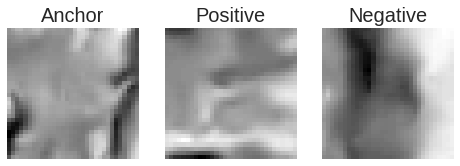

In [91]:
plot_triplet(training_generator)
#just to make sure the denoiser is decent

We now train the descriptor model and save the weights afterward.

In [0]:
### As with the denoising model, we use a loop to save for each epoch 
## #the weights in an external website in case colab stops. 
### reset, so e.g. calling 5 times fit(epochs=1) behave as fit(epochs=5)

### If you have a model saved from a previous training session
### Load it in the next line
# descriptor_model_trip.set_weights(keras.models.load_model('./descriptor.h5').get_weights())
# descriptor_model_trip.optimizer = keras.models.load_model('./descriptor.h5').optimizer


descriptor_history = descriptor_model_trip.fit_generator(generator=training_generator, epochs=15, verbose=1, validation_data=val_generator, callbacks=[TensorBoardColabCallback(tboard)])

### Saves optimizer and weights
descriptor_model_trip.save('descriptor_model.h5') 
### Uploads files to external hosting
!curl -F "file=@descriptor.h5" https://file.io


Epoch 1/15
39999/40000 [============================>.] - ETA: 0s - loss: 0.0619



  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 2431/2000000 [00:00<01:22, 24218.50it/s]

  0%|          | 5079/2000000 [00:00<01:20, 24665.92it/s]

  0%|          | 7677/2000000 [00:00<01:22, 24201.36it/s]

  0%|          | 9534/2000000 [00:00<01:29, 22164.57it/s]

  1%|          | 11984/2000000 [00:00<01:27, 22816.88it/s]

  1%|          | 14900/2000000 [00:00<01:21, 24407.88it/s]

  1%|          | 17829/2000000 [00:00<01:17, 25631.25it/s]

  1%|          | 20246/2000000 [00:00<01:20, 24496.19it/s]

  1%|          | 22768/2000000 [00:00<01:20, 24705.30it/s]

  1%|▏         | 25175/2000000 [00:01<01:24, 23406.24it/s]

  1%|▏         | 27485/2000000 [00:01<01:28, 22380.57it/s]

  2%|▏         | 30230/2000000 [00:01<01:23, 23692.96it/s]

  2%|▏         | 32612/2000000 [00:01<01:23, 23609.56it/s]

  2%|▏         | 34982/2000000 [00:01<01:24, 23301.21it/s]

  2%|▏         | 38347/2000000 [00:01<01:16, 25669.49it/s]

  2%|▏         | 41263/2000000 [00:01<01:13, 26625.27it/s

40000/40000 [==============================] - 3282s 82ms/step - loss: 0.0619 - val_loss: 0.1927


Epoch 2/15




 60%|█████▉    | 1197832/2000000 [00:50<00:53, 15061.55it/s]

 60%|██████    | 1200134/2000000 [00:51<01:35, 8347.33it/s] 


  0%|          | 0/100000 [00:00<?, ?it/s]

 60%|██████    | 1202251/2000000 [00:51<01:18, 10200.91it/s]


  1%|          | 694/100000 [00:00<00:14, 6931.68it/s]


  1%|▏         | 1365/100000 [00:00<00:14, 6862.81it/s]

 60%|██████    | 1204100/2000000 [00:51<01:21, 9792.19it/s] 


  2%|▏         | 2420/100000 [00:00<00:12, 7665.01it/s]

 60%|██████    | 1205663/2000000 [00:51<01:17, 10206.89it/s]


  3%|▎         | 3143/100000 [00:00<00:12, 7528.99it/s]


  4%|▍         | 3812/100000 [00:00<00:13, 7255.81it/s]

 60%|██████    | 1207097/2000000 [00:51<01:27, 9042.10it/s] 


  5%|▍         | 4735/100000 [00:00<00:12, 7753.00it/s]


  5%|▌         | 5488/100000 [00:00<00:12, 7681.22it/s]

 60%|██████    | 1208315/2000000 [00:52<01:37, 8083.33it/s]


  6%|▋         | 6371/100000 [00:00<00:11, 7978.33it/s]

 60%|██████    | 1209362/2000000 [00:52<01:33, 8456.80it/

19595/40000 [=============>................] - ETA: 28:02 - loss: 0.0513Buffered data was truncated after reaching the output size limit.

## Generating descriptors files for test data 

To evaluate the performance of out model we will use an existing evaluation code, which is called HPatches benchmark. HPatches benchmark takes as input the descriptors for the test data in a CSV form. So the whole pipeline is represented in the following image.

![](https://i.ibb.co/WcDDf3q/Screenshot-from-2019-02-15-11-17-24.png)

This function generates those files by passing it a descriptor model and a denoising model. It performs a first step of denoising the patches, and a second one of computing the descriptor of the denoised patch. If no denoising model is given (variable set to `None`), the descriptor is computed directly in the noisy patch.

Similarly to the loading data part, you have the denoise_model variable and `use_clean` variable. If `use_clean` is set to True, the CSV generated will be those of the clean patches, even if a denoising model is given. If set to False, then depends on the variable `denoise_model`. If there is no denoise model (`denoise_model=None`), then it will use the noisy patches. If you give a denoising model, then it will compute the CSV for the denoised patches. This can be useful to explore different scenarios (for example, the Upper Bound can be training the descriptor network with clean patches, and testing with clean patches), however you should always report the score when using noisy patches (depending on the approach you develop, you may want to denoise them or not). The official baseline uses the denoised patches. 

Exception tensorflow.python.framework.errors_impl.InvalidArgumentError: InvalidArgumentError() in <bound method _Callable.__del__ of <tensorflow.python.client.session._Callable object at 0x7f12c05e1cd0>> ignored


NameError: ignored

In [61]:

generate_desc_csv(descriptor_model, seqs_test, denoise_model=denoise_model, use_clean=False)



  0%|          | 0/40 [00:00<?, ?it/s]

  2%|▎         | 1/40 [00:08<05:12,  8.00s/it]

  5%|▌         | 2/40 [00:19<05:49,  9.20s/it]

  8%|▊         | 3/40 [00:32<06:22, 10.34s/it]

 10%|█         | 4/40 [00:46<06:42, 11.17s/it]

 12%|█▎        | 5/40 [00:56<06:27, 11.07s/it]

 15%|█▌        | 6/40 [01:09<06:30, 11.47s/it]

 18%|█▊        | 7/40 [01:22<06:35, 11.97s/it]

 20%|██        | 8/40 [01:33<06:09, 11.54s/it]

 22%|██▎       | 9/40 [01:43<05:44, 11.12s/it]

 25%|██▌       | 10/40 [01:47<04:32,  9.08s/it]

 28%|██▊       | 11/40 [02:00<04:58, 10.28s/it]

 30%|███       | 12/40 [02:03<03:45,  8.04s/it]

 32%|███▎      | 13/40 [02:08<03:11,  7.10s/it]

 35%|███▌      | 14/40 [02:11<02:34,  5.94s/it]

 38%|███▊      | 15/40 [02:18<02:37,  6.32s/it]

 40%|████      | 16/40 [02:29<03:04,  7.68s/it]

 42%|████▎     | 17/40 [02:42<03:34,  9.34s/it]

 45%|████▌     | 18/40 [02:55<03:50, 10.50s/it]

 48%|████▊     | 19/40 [03:09<03:57, 11.29s/it]

 50%|█████     | 20/40 [03:15<03:17,

## Evaluating descriptors in HPatches Benchmark
We use HPatches benchmark code to compute the results for our model. 

**Updated**: The necessary code is included in the repository we cloned at the beginning of the code, so we do not need to download any extra data. Also, we simplified the results, so now they only return one value for each of the three tasks.

Now we will perform the evaluation of three different tasks (Verification, Matching and Evaluation) using the CSV files we generated as input and the `hpatches_eval.py` script. We also print the results using the `hpatches_results.py` script. The scripts will return a score for each of the tasks. The metric used is called mean Average Precision, which it uses the Precision of the model. The Precision is defined, for a given number of retrieved elements, as the ratio of correct retrieved elements / number of retrieved elements. [Link to Wikipedia with Precision explanation](https://en.wikipedia.org/wiki/Precision_and_recall). The definition of the three different tasks is taken from the [HPatches paper](https://arxiv.org/pdf/1704.05939.pdf).

In all of the tasks if you use the optional argument `--more_info` in `hpatches_results.py` you can see extra mAP information. However, the important score is the mAP score reported without this flag.

### Verification

Patch verification measures the ability of a descriptor to classify whether two patches are extracted from the same measurement. Now we compute the score of our architecture in this task.




In [62]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=verification --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=verification



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating verification task
Processing verification task 1/3 : 100% 1000000/1000000 [01:29<00:00, 11181.80it/s]
Processing verification task 2/3 : 100% 1000000/1000000 [01:29<00:00, 11130.71it/s]
Processing verification task 3/3 : 100% 1000000/1000000 [01:29<00:00, 11144.83it/s]
>> Verification task finished in 277 secs  
Verification task results:
Mean Average Precision is 0.787391




### Matching
Image matching, tests to what extent a descriptor can correctly identify correspondences in two images.

In [63]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=matching --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=matching



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating matching task
100% 40/40 [02:06<00:00,  4.29s/it]
>> Matching task finished in 127 secs  
Matching task results:
Mean Average Precision is 0.189140






### Retrieval
Retrieval tests how well a descriptor can match a query patch to a pool of patches extracted from many images.

In [64]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=retrieval --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=retrieval


>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating retrieval task
>> Please wait, computing distance matrix...
tcmalloc: large alloc 1600004096 bytes == 0x5600ef718000 @  0x7f3d67e5c1e7 0x7f3d5da5dcf1 0x7f3d5dac03a2 0x7f3d5dac20de 0x7f3d5db590e8 0x5600c7769fe5 0x5600c775fd0a 0x5600c77675fe 0x5600c7767232 0x5600c775fd0a 0x5600c7767c38 0x5600c775fd0a 0x5600c775f629 0x5600c779061f 0x5600c778b322 0x5600c778a67d 0x5600c77391ab 0x7f3d67a59b97 0x5600c7738a2a
>> Distance matrix done.
Processing retrieval task: 100% 10000/10000 [03:48<00:00, 43.71it/s]
>> Retrieval task finished in 247 secs  
Retrieval task results:
Mean Average Precision is 0.485288




## Compressing and saving the CSV files 

This is not necessary for the analysis of the baseline code included in the report. However, we will be hosting a competition in an external website to see who can achieve the highest score. In that case, you will need to submit the CSV files, as the scoring script will be performed in an external server. With that aim, we include here a way to save the files either in your local disc or in your google drive account.

We first compress the directory with all the CSV by using the following command. Remove the `q` option if you want it to output the progress.

In [0]:
!zip -rq descriptors.zip ./out/custom

The generated .zip is quite large, the method we used for the weights does not work. We have two other methods. First, in the file explorer in the left column we can right-click in the file and then click download. Then, we will see a circle next to the file showing the download progress.

The second way does not require for you to download the files, it save the zip file in your Google Drive account, and you can download it later to your machine if you want. To do so, follow this method (found [here](https://stackoverflow.com/questions/49428332/how-to-download-large-files-like-weights-of-a-model-from-colaboratory)). First run the next cell, and the output will be a link for authentication purposes, and just follow the instructions

In [66]:
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()
drive_service = build('drive', 'v3')

def save_file_to_drive(name, path):
  file_metadata = {
    'name': name,
    'mimeType': 'application/octet-stream'
  }

  media = MediaFileUpload(path, 
                          mimetype='application/octet-stream',
                          resumable=True)

  created = drive_service.files().create(body=file_metadata,
                                  media_body=media,
                                  fields='id').execute()

  print('File ID: {}'.format(created.get('id')))

  return created


Exception tensorflow.python.framework.errors_impl.InvalidArgumentError: InvalidArgumentError() in <bound method _Callable.__del__ of <tensorflow.python.client.session._Callable object at 0x7f12c05e57d0>> ignored


KeyboardInterrupt: ignored

Now we can use the following function to save the file to your drive account. The second argument is the name of the file we want to save, and the first argument the name that will have in your Drive.

In [0]:
save_file_to_drive('descriptors_save.zip', 'descriptors.zip')